## Hierarchy Classificator Complete Study

With all the information gathered with `HierarchyClassificatorLevelStudy.ipynb` we've created the 3 layer model called `HerarchyModel.py` that takes 3 trained models and uses this herarchy structure to predict different attacks.

In [7]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install fastparquet
!pip uninstall tensorflow
!pip install tensorflow
#!pip install keras
#!pip uninstall xgboost
#!pip install xgboost



Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Nico\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Nico\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from models.HerarchyModel.HierarchyModel import HerarchyModel

from fastparquet import ParquetFile


ModuleNotFoundError: No module named 'tensorflow.python'

# Complete Datset

In [ ]:
data = pd.read_parquet('Datasets/Complete/cic-collection.parquet')

In [ ]:
data.columns = data.columns.str.strip()
data.rename(columns={'Label': 'AttackType'}, inplace=True)

data = data[data['AttackType'].str.contains('Webattack-Bruteforce|Webattack-XSS|Webattack-SQLi', case=False)]


data['AttackType'] = data['AttackType'].str.replace('Webattack-bruteforce', 'BruteForce', case=False)
data['AttackType'] = data['AttackType'].str.replace('Webattack-XSS', 'XSS', case=False)
data['AttackType'] = data['AttackType'].str.replace('Webattack-SQLi', 'SQLInjection', case=False)

print(data['AttackType'].value_counts())

AttackType
BruteForce      2020
XSS              876
SQLInjection      99
Name: count, dtype: int64


In [ ]:
dataDdos = pd.read_csv('Datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
dataPortScan = pd.read_csv('Datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
dataWebAttacks = pd.read_csv('Datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')

dataSmall = pd.concat([dataDdos, dataPortScan, dataWebAttacks], ignore_index=True)

dataSmall.columns = dataSmall.columns.str.strip()

dataSmall.rename(columns={'Label': 'AttackType'}, inplace=True)
dataSmall['AttackType'] = dataSmall['AttackType'].str.replace('�', '-')

print(dataSmall['AttackType'].value_counts())

AttackType
BENIGN                        393441
PortScan                      158930
DDoS                          128027
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Web Attack - Sql Injection        21
Name: count, dtype: int64


In [ ]:
dataSmall['AttackType'] = dataSmall['AttackType'].str.replace('Web Attack - Brute Force', 'BruteForce')
dataSmall['AttackType'] = dataSmall['AttackType'].str.replace('Web Attack - XSS', 'XSS')
dataSmall['AttackType'] = dataSmall['AttackType'].str.replace('Web Attack - Sql Injection', 'SQLInjection')
print(dataSmall['AttackType'].value_counts())

AttackType
BENIGN          393441
PortScan        158930
DDoS            128027
BruteForce        1507
XSS                652
SQLInjection        21
Name: count, dtype: int64


In [ ]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
dataSmall.replace([np.inf, -np.inf], np.nan, inplace=True)
dataSmall.dropna(inplace=True)

# Check if dataSmall and data have the same columns
columns_data = set(data.columns)
columns_dataSmall = set(dataSmall.columns)

if columns_data == columns_dataSmall:
    print("dataSmall and data have the same columns.")
else:
    print("dataSmall and data do not have the same columns.")
    print("Columns in data but not in dataSmall:", columns_data - columns_dataSmall)
    print("Columns in dataSmall but not in data:", columns_dataSmall - columns_data)
    
    shared_columns = columns_data.intersection(columns_dataSmall)
    print(f"Number of columns they share: {len(shared_columns)}")

shared_columns = list(shared_columns)
data = data[shared_columns]
dataSmall = dataSmall[shared_columns]


dataSmall and data do not have the same columns.
Columns in data but not in dataSmall: {'Avg Packet Size', 'Fwd Packets Length Total', 'Fwd Act Data Packets', 'Init Fwd Win Bytes', 'ClassLabel', 'Bwd Packets Length Total', 'Packet Length Max', 'Init Bwd Win Bytes', 'Fwd Seg Size Min'}
Columns in dataSmall but not in data: {'FIN Flag Count', 'Min Packet Length', 'min_seg_size_forward', 'Bwd PSH Flags', 'Bwd Avg Packets/Bulk', 'Init_Win_bytes_forward', 'act_data_pkt_fwd', 'Down/Up Ratio', 'Max Packet Length', 'ACK Flag Count', 'ECE Flag Count', 'Total Length of Bwd Packets', 'Bwd URG Flags', 'Total Length of Fwd Packets', 'Bwd Avg Bulk Rate', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk', 'Fwd Packet Length Min', 'Init_Win_bytes_backward', 'Fwd Header Length.1', 'Average Packet Size', 'CWE Flag Count', 'PSH Flag Count', 'Bwd Packet Length Min', 'Bwd Avg Bytes/Bulk', 'Fwd URG Flags', 'Destination Port', 'RST Flag Count'}
Number of columns they share: 50


In [ ]:
dataset = pd.concat([data, dataSmall], ignore_index=True)

dataset.to_csv('Datasets/Complete/Dataset.csv', index=False)
dataset.shape


(685033, 50)

# Training

We will retrain the models again, this time with the complete Datset, so we don't have any inconsistencies. We will be taking the parameters that performed best in each layer study.

### Level 1 - Random Forest

MALIGN - BENIGN

In [ ]:
X = dataset.drop('AttackType', axis=1)
y = dataset['AttackType']

In [ ]:
target_classes = {
    "BruteForce": 50000,
    "XSS": 50000,
    "SQLInjection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts())

AttackType
BENIGN          393029
PortScan        158804
DDoS            128025
BruteForce       50000
XSS              50000
SQLInjection     50000
Name: count, dtype: int64


In [ ]:
y_resampled = y_resampled.apply(lambda x: 'MALIGN' if x != 'BENIGN' else x)
print(y_resampled.value_counts())


AttackType
MALIGN    436829
BENIGN    393029
Name: count, dtype: int64


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      BENIGN       0.99      1.00      1.00     78452
      MALIGN       1.00      1.00      1.00     87520

    accuracy                           1.00    165972
   macro avg       1.00      1.00      1.00    165972
weighted avg       1.00      1.00      1.00    165972



We now save the model

In [ ]:
import joblib

joblib_file = "LayerModels/lvl1_rf_model.pkl"
joblib.dump(rf, joblib_file)

print("Model saved to", joblib_file)

Model saved to LayerModels/lvl1_rf_model.pkl


## Level 2 - Neural Network
DDos vs PortScan vs WebAttack

In [ ]:
X_2 = X[y != 'BENIGN']
y_2 = y[y != 'BENIGN']

target_classes = {
    "BruteForce": 50000,
    "XSS": 50000,
    "SQLInjection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_2, y_2)

print(y_resampled.value_counts())

AttackType
PortScan        158804
DDoS            128025
BruteForce       50000
XSS              50000
SQLInjection     50000
Name: count, dtype: int64


In [ ]:
y_resampled = y_resampled.apply(lambda x: 'WebAttack' if "BruteForce" in x else x)
y_resampled = y_resampled.apply(lambda x: 'WebAttack' if "XSS" in x else x)
y_resampled = y_resampled.apply(lambda x: 'WebAttack' if "SQLInjection" in x else x)
print(y_resampled.value_counts())

AttackType
PortScan     158804
WebAttack    150000
DDoS         128025
Name: count, dtype: int64


In [ ]:
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

X_resampled_scaled = pd.DataFrame(X_resampled_scaled, columns=X_resampled.columns)

X_resampled_scaled.describe()

,Fwd IAT Std,Bwd Packet Length Max,Idle Mean,Subflow Fwd Packets,Fwd IAT Min,Bwd IAT Max,Idle Min,Idle Std,Bwd IAT Total,Avg Fwd Segment Size,...,Fwd IAT Max,URG Flag Count,Flow Duration,Fwd IAT Mean,Fwd Packet Length Mean,Bwd IAT Mean,SYN Flag Count,Flow IAT Mean,Flow IAT Max,Packet Length Std
count,436829.000000,436829.000000,436829.000000,436829.000000,4.368290e+05,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,...,436829.000000,436829.000000,4.368290e+05,436829.000000,436829.000000,436829.000000,436829.000000,4.368290e+05,4.368290e+05,436829.000000
mean,0.045557,0.130556,0.030554,0.025899,6.649953e-04,0.003844,0.022312,0.021438,0.012375,0.030363,...,0.049423,0.029952,6.551843e-02,0.011962,0.030363,0.001367,0.000002,1.859379e-02,5.213140e-02,0.109927
std,0.111454,0.257076,0.116213,0.124527,1.635867e-02,0.014993,0.102588,0.123741,0.063134,0.088117,...,0.143457,0.170456,1.693511e-01,0.028750,0.088117,0.011874,0.001513,4.333018e-02,1.428156e-01,0.213111
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.999999e-08,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.256749e-07,0.000000,0.000000,0.000000,0.000000,9.114475e-07,4.250000e-07,0.000000
50%,0.000022,0.000517,0.000000,0.009479,1.250000e-07,0.000000,0.000000,0.000000,0.000000,0.002867,...,0.000025,0.000000,4.939532e-03,0.000014,0.002867,0.000000,0.000000,1.515349e-03,4.883150e-03,0.000488
75%,0.062705,0.115077,0.000000,0.014218,3.323061e-06,0.000206,0.000000,0.000000,0.000257,0.010034,...,0.043448,0.000000,4.480956e-02,0.020883,0.010034,0.000063,0.000000,3.047102e-02,4.344787e-02,0.094638
max,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000


In [ ]:
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)
unique, counts = np.unique(y_resampled_encoded, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(128025), np.int64(1): np.int64(158804), np.int64(2): np.int64(150000)}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled_encoded, test_size=0.2, random_state=42)


model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # Primera capa oculta con 128 nodos
    Dropout(0.3),  # Dropout para prevenir sobreajuste
    Dense(64, activation='relu'),  # Segunda capa oculta con 64 nodos
    Dropout(0.3),
    Dense(3, activation='softmax')  # Capa de salida para clasificación multiclase (3 clases)
])

# 6. Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Para problemas multiclase
              metrics=['accuracy'])

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Entrenar el modelo
history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50


/Users/nico/Desktop/UPC/PAE/SentinelX/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8737/8737 ━━━━━━━━━━━━━━━━━━━━ 4s 385us/step - accuracy: 0.9749 - loss: 0.1011 - val_accuracy: 0.9994 - val_loss: 0.0049
Epoch 2/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 4s 426us/step - accuracy: 0.9991 - loss: 0.0056 - val_accuracy: 0.9994 - val_loss: 0.0033
Epoch 3/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step - accuracy: 0.9991 - loss: 0.0044 - val_accuracy: 0.9995 - val_loss: 0.0033
Epoch 4/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 379us/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9996 - val_loss: 0.0026
Epoch 5/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 376us/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9997 - val_loss: 0.0025
Epoch 6/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 378us/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 0.9996 - val_loss: 0.0023
Epoch 7/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 377us/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9997 - val_loss: 0.0024
Epoch 8/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 372us/step - accuracy: 0.9996 - loss: 0.00

2731/2731 ━━━━━━━━━━━━━━━━━━━━ 1s 226us/step


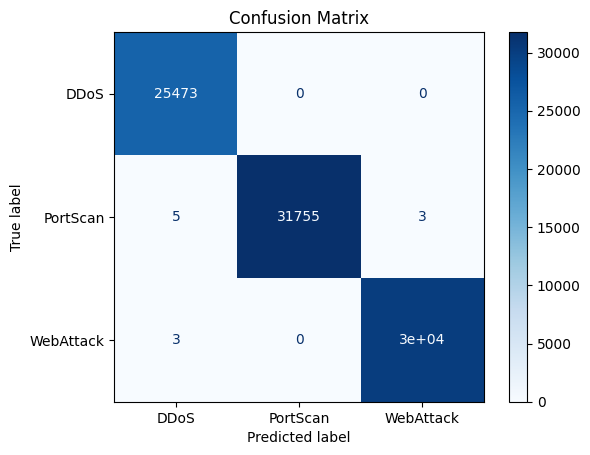

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [ ]:

# Predict the labels for the test set
y_pred_nn = model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_nn_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print other performance metrics
accuracy = accuracy_score(y_test, y_pred_nn_classes)
precision = precision_score(y_test, y_pred_nn_classes, average='weighted')
recall = recall_score(y_test, y_pred_nn_classes, average='weighted')
f1 = f1_score(y_test, y_pred_nn_classes, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

In [ ]:
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(class_mapping)

{'DDoS': np.int64(0), 'PortScan': np.int64(1), 'WebAttack': np.int64(2)}


In [ ]:
import joblib

joblib_file = "LayerModels/lvl2_nn_model.keras"
joblib.dump(model, joblib_file)

print("Model saved to", joblib_file)

Model saved to LayerModels/lvl2_nn_model.keras


### Level 3 - XGBoost

BruteForce vs XSS vs SQLInjection

In [ ]:
dataset = dataset[~dataset['AttackType'].isin(['BENIGN', 'PortScan', 'DDoS'])]

X = dataset.drop(columns=['AttackType'])
y = dataset['AttackType']

In [ ]:
target_classes = {
    "BruteForce": 50000,
    "XSS": 50000,
    "SQLInjection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts())

AttackType
BruteForce      50000
XSS             50000
SQLInjection    50000
Name: count, dtype: int64


In [ ]:
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

X_resampled_scaled = pd.DataFrame(X_resampled_scaled, columns=X_resampled.columns)

X_resampled_scaled.describe()

,Fwd IAT Std,Bwd Packet Length Max,Idle Mean,Subflow Fwd Packets,Fwd IAT Min,Bwd IAT Max,Idle Min,Idle Std,Bwd IAT Total,Avg Fwd Segment Size,...,Fwd IAT Max,URG Flag Count,Flow Duration,Fwd IAT Mean,Fwd Packet Length Mean,Bwd IAT Mean,SYN Flag Count,Flow IAT Mean,Flow IAT Max,Packet Length Std
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.00000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.155798,0.059209,0.006451,0.061290,0.002643,0.176609,0.003336,0.012381,0.054995,0.077837,...,0.069851,0.08718,0.073689,0.032521,0.077837,0.090796,0.000007,0.025139,0.081944,0.107954
std,0.149527,0.112220,0.059051,0.207489,0.042527,0.364832,0.044088,0.110348,0.176002,0.138325,...,0.096107,0.28210,0.136797,0.056343,0.138325,0.195375,0.002582,0.054172,0.092227,0.192855
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000695,0.000000,0.000000,0.009479,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000429,0.00000,0.044456,0.000146,0.000000,0.000000,0.000000,0.004806,0.064768,0.000000
50%,0.230809,0.000000,0.000000,0.009479,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.088973,0.00000,0.045987,0.044487,0.000000,0.000000,0.000000,0.029658,0.088973,0.000000
75%,0.252117,0.049345,0.000000,0.014218,0.000016,0.000814,0.000000,0.000000,0.000084,0.171732,...,0.097216,0.00000,0.050089,0.048615,0.171732,0.000889,0.000000,0.032410,0.097216,0.150857
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)
unique, counts = np.unique(y_resampled_encoded, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(50000), np.int64(1): np.int64(50000), np.int64(2): np.int64(50000)}


In [ ]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled_encoded, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=9,
    n_estimators=200,
    subsample=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      9938
           1       0.98      0.99      0.99     10110
           2       0.98      0.98      0.98      9952

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000



In [ ]:
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(class_mapping)

{'BruteForce': np.int64(0), 'SQLInjection': np.int64(1), 'XSS': np.int64(2)}


In [ ]:
import joblib

# Save the model to a file
joblib_file = "LayerModels/lvl3_xgboost_model.pkl"
joblib.dump(xgb_model, joblib_file)

print(f"Model saved to {joblib_file}")

Model saved to LayerModels/lvl3_xgboost_model.pkl
